**DS 301: Applied Data Modeling and Predictive Analysis**

# Lab 6 – Support Vector Machine

Nok Wongpiromsarn, 8 August 2022

**Instructions:**
1. Construct a pandas dataframe from Iris dataset.
2. Remove outliers. Here, we define outliers as those that are beyond 1.5 times the IQR above the upper quartile or below the lower quartile.
3. Apply each of the following methods to deal with the missing features. Discuss the differences in the data obtained from these methods.
   - dropna
   - fillna
   - SimpleImputer
4. Use the dataframe obtained from dropna. Visualize the data to see which pairs of the 3 species (setosa, versicolor, virginica) are linearly separable.
5. Construct features X and labels y.
   - X contains only the petal length and petal width features.
   - y is a binary target such that it is 1 if the instance is Virginica and is 0 otherwise.
6. Train LinearSVC, SVC, and SGDClassifier to identify whether a given instance is Virginica. Use C = 1. Don't forget to scale your data!
7. Pick one of the 3 classifiers and report the following performance measures.
   1. training accuracy
   2. cross-validation accuracy
   3. confusion matrix
   4. precision
   5. recall
   6. F1
   7. AUC

### 1. Construct a pandas dataframe from Iris dataset

In [18]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
df_feature = pd.DataFrame(iris['data'], columns = iris.feature_names)
df_label = pd.DataFrame(iris['target'], columns = ['species'])
df = pd.concat([df_feature, df_label], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


### 2. Remove outliers.

Here, we define outliers as those that are beyond 1.5 times the IQR above the upper quartile or below the lower quartile.

**2.1 Use boxplot to determine outliers.**

<AxesSubplot:>

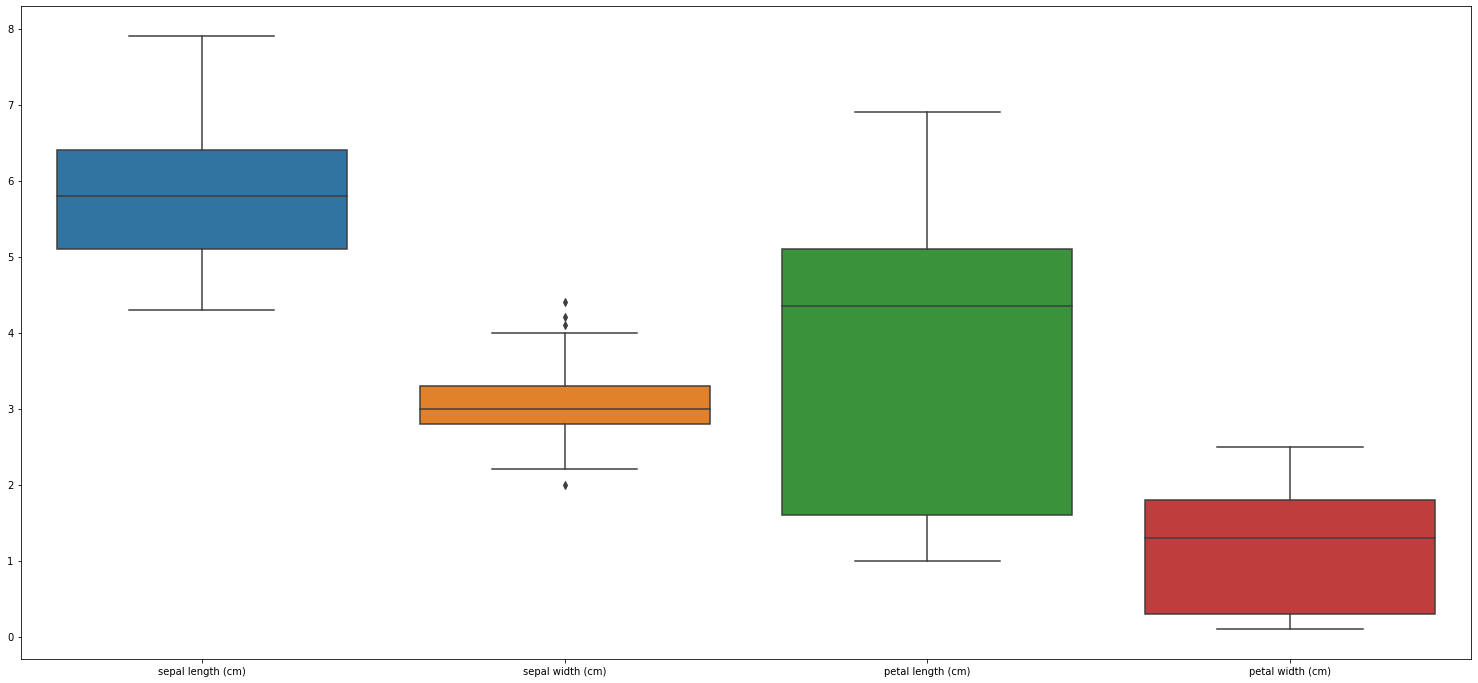

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(26, 12))
sns.boxplot(data=df[iris.feature_names])

**2.2 Replace all the outliers with NaN.**

In [23]:
import numpy as np

Q3 = df['sepal width (cm)'].quantile(0.75)
Q1 = df['sepal width (cm)'].quantile(0.25)
IQR = Q3 - Q1

# Set the values of sepal width that are beyond 1.5 times the IQR above the upper quartile as NaN
df.loc[df['sepal width (cm)'] > Q3 + 1.5*IQR, 'sepal width (cm)'] = np.nan

# TODO: Set other outliers as NaN
df.loc[df['sepal width (cm)'] < Q1 - 1.5*IQR, 'sepal width (cm)'] = np.nan
# I only removed the outliers from the sepal width data since the rest of the plots did not have any outliers on the plot
# There were only 4 outliers in the sepal width data.

# Call info to verify that NaN values show up as null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   146 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


### 3. Apply each of the following methods to deal with the missing features

- dropna
- fillna
- SimpleImputer

First, we identify all the rows with null

In [25]:
rows_with_null = df.isnull().any(axis=1)
df[rows_with_null]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
15,5.7,NaN,1.5,0.4,0
32,5.2,NaN,1.5,0.1,0
33,5.5,NaN,1.4,0.2,0
60,5.0,NaN,3.5,1.0,1


**3.1 dropna**

In [42]:
df_dropna = df.dropna(subset=["sepal width (cm)"])

# TODO: Use a combination of info(), head(), describe(), and X_dropna[rows_with_null] 
# to see the difference between df and df_dropna
df_dropna.info()
df_dropna
df_dropna.describe()
# df_dropna now shows only the data points that had all non-null data. Dropped the points in sepal length, petal length, petal width, and species that corresponds to the null values from sepal width.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  146 non-null    float64
 1   sepal width (cm)   146 non-null    float64
 2   petal length (cm)  146 non-null    float64
 3   petal width (cm)   146 non-null    float64
 4   species            146 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 6.3 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,146.000000,146.000000,146.000000,146.000000,146.000000
mean,5.856849,3.040411,3.806849,1.220548,1.020548
std,0.834093,0.397853,1.758042,0.759393,0.817643
min,4.300000,2.200000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.400000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.000000,6.900000,2.500000,2.000000


**3.2 fillna**

In [43]:
# TODO: Change val to some other value that is not the mean of df['sepal width (cm)']
val = df['sepal width (cm)'].mean()
df_fillna = df.copy()
df_fillna['sepal width (cm)'] = df['sepal width (cm)'].fillna(val * 1.25)

# TODO: Use a combination of info(), head(), describe(), and df_fillna[rows_with_null] 
# to see the difference between df and df_fillna
df_fillna.info()
df_fillna.head()
df_fillna.describe()
df_fillna
#Fills na values with the value that was given. Originally it was the mean, I changed it to the mean * 1.25 for variation.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


**3.3 SimpleImputer**

In [46]:
from sklearn.impute import SimpleImputer

# TODO: Change strategy to something that is not "mean"
imputer = SimpleImputer(strategy="median")
df_imputer = imputer.fit_transform(df)

# TODO: Check the type of df_imputer and call df_imputer[rows_with_null]
# to see the difference between df, df_fillna, and df_imputer
df_imputer.dtype
df_imputer[rows_with_null]
df_imputer
# After changing the imputer strategy to median, it uses the median along the column to impute values.

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 3. , 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

### 4. Visualize the data to see which pair of the 3 species are linearly separable.

First, we separate the input based on their labels to help with plotting

In [48]:
X_setosa = df_dropna.loc[df_dropna['species'] == 0, iris.feature_names]
X_versicolor = df_dropna.loc[df_dropna['species'] == 1, iris.feature_names]
X_virginica = df_dropna.loc[df_dropna['species'] == 2, iris.feature_names]

**4.1 Scatter plot of sepal length VS sepal width. Use different color for different species.**

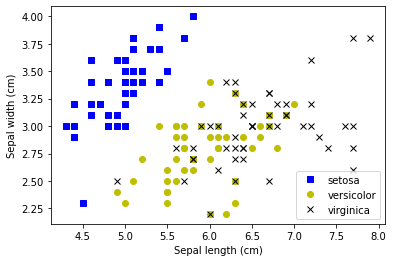

In [49]:
plt.plot(X_setosa[['sepal length (cm)']], X_setosa[['sepal width (cm)']], 'bs', label='setosa')
plt.plot(X_versicolor[['sepal length (cm)']], X_versicolor[['sepal width (cm)']], 'yo', label='versicolor')
plt.plot(X_virginica[['sepal length (cm)']], X_virginica[['sepal width (cm)']], 'kx', label='virginica')
plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.legend()
plt.show()

**4.2 Scatter plot of petal length VS petal width. Use different color for different species.**

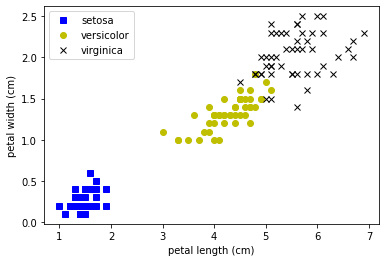

In [50]:
#TODO
plt.plot(X_setosa[['petal length (cm)']], X_setosa[['petal width (cm)']], 'bs', label='setosa')
plt.plot(X_versicolor[['petal length (cm)']], X_versicolor[['petal width (cm)']], 'yo', label='versicolor')
plt.plot(X_virginica[['petal length (cm)']], X_virginica[['petal width (cm)']], 'kx', label='virginica')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.legend()
plt.show()

**Based on the above 2 plots, which pairs of the 3 species (setosa, versicolor, virginica) are linearly separable?**

Setosa and Versicolor

### 5. Construct features X and labels y. 

- X contains only the petal length and petal width features.
- y is a binary target such that it is 1 if the instance is Virginica and is 0 otherwise.

In [56]:
df_dropna

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [63]:
X = df_dropna[['petal length (cm)', 'petal width (cm)']] # petal length, petal width

# TODO: Set the correct value of species that corresponds to Virginica.
# Hint: Use iris['target_names'] to figure out the right index.
y = df_dropna['species'] == 2
y

0      False
1      False
2      False
3      False
4      False
       ...  
145     True
146     True
147     True
148     True
149     True
Name: species, Length: 146, dtype: bool

### 6. Train LinearSVC, SVC, and SGDClassifier to identify whether a given instance is Virginica.

In [80]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 1
alpha = 1 / (C * len(X))

# Construct the classifiers
lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", alpha=alpha, max_iter=1000, tol=1e-3, random_state=42)

# TODO: Scale the features and train the classifiers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)


SGDClassifier(alpha=0.00684931506849315, random_state=42)

### 4. Pick one of the 3 classifiers and report the following performance measures

- training accuracy
- cross-validation accuracy
- confusion matrix
- precision
- recall
- F1
- AUC


**Training Accuracy**

In [81]:
# TODO
from sklearn import metrics
print(metrics.accuracy_score(y, lin_clf.predict(X_scaled)))

0.952054794520548


**Cross-Validation Accuracy**

In [82]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(lin_clf, X_scaled,y, cv = 3, scoring = "accuracy"))

[0.97959184 0.95918367 0.91666667]


**Confusion Matrix**

In [83]:
from sklearn.model_selection import cross_val_predict
lin_clf_pred = cross_val_predict(lin_clf, X_scaled, y ,cv = 3)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, lin_clf_pred))

[[93  3]
 [ 4 46]]


**Precision, Recall, F1**

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision Score:", precision_score(y, lin_clf_pred))
print("Recall Score: ", recall_score(y, lin_clf_pred))
print("F1 Score:", f1_score(y, lin_clf_pred))

Precision Score: 0.9387755102040817
Recall Score:  0.92
F1 Score: 0.9292929292929293


**AUC**

In [89]:
from sklearn.metrics import roc_auc_score
y_lin_score = cross_val_predict(lin_clf, X_scaled, y ,cv = 3, method = "predict")

print(roc_auc_score(y, y_lin_score[:]))

0.944375
